# Import

In [1]:
try:
    from importlib import reload
except:
    pass
import pipeline; reload(pipeline)
import visualization; reload(visualization)
from pipeline import *
from visualization import *
from openalea.plantgl.all import *
from os.path import join, exists
import os.path as op


# Test of automatic reconstruction

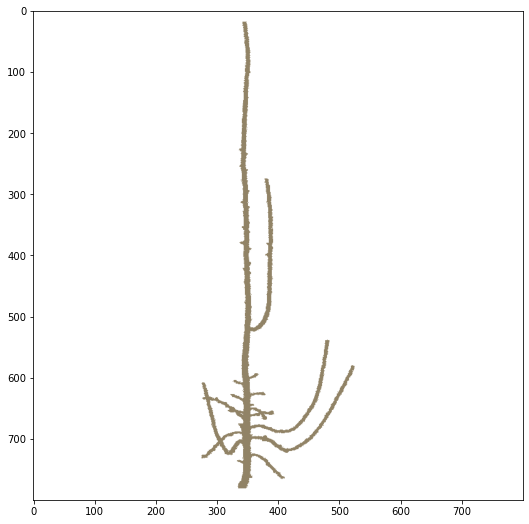

Remove short nodes  


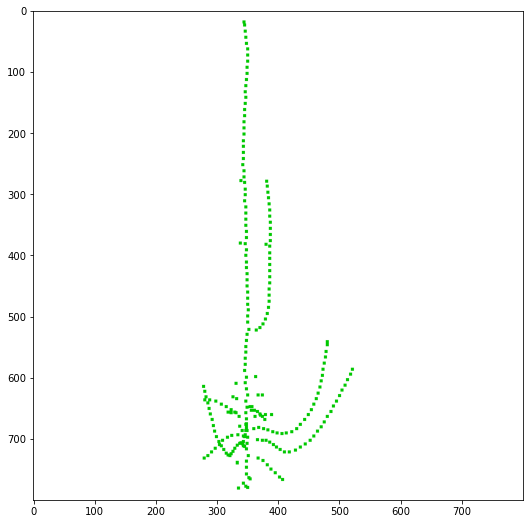

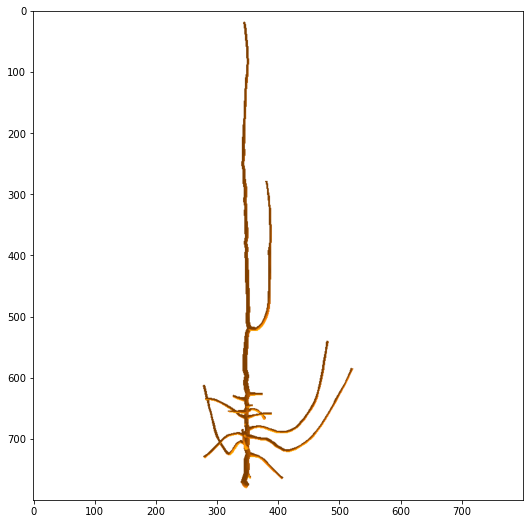

In [2]:
filename = join('benchmark_data','GDR_12_r1.txt')
points = load_points(filename)
#points = subsample(points, 10000)
points = filter_points(points)
view_points(points)

#cpoints = contract_point3(points, 0.03)
#view_points(cpoints)

mtg = skeleton(points, 75)
view(nodemtg_to_scene(mtg))
# should add rendering of polyline

determine_radius(mtg, points)
view(mtg_to_scene(mtg))

# Automatic processing of the scans

In [3]:
def writefile(fn, obj):
    try:
        import cPickle as pickle
    except:
        import pickle
    f = open(fn,'wb')
    protocol = 2 # compatible between python 2 and 3
    pickle.dump(obj, f, protocol)
    f.close()

    
def characterize_mtg(g):
    shortaxis, longaxis = trunk_lateral_axes(g)
    trunk_dir = trunk_direction(g, 0.5)
    trunkbaseradius, trunktopradius = trunk_radii(g, 0.1, 0.1)
    
    res = dict(
        trunk_length = trunk_length(g),
        trunk_branching_zone_start = trunk_branching_zone_start(g),
        trunk_branching_zone_end = trunk_branching_zone_end(g),
        trunk_branching_zone_length = trunk_branching_zone_length(g),
        trunk_base_radius = trunkbaseradius,
        trunk_top_radius = trunktopradius,
        nb_short_axis = len(shortaxis),
        nb_long_axis = len(longaxis),
    )
    
    bot_angle_param = 0, 0.15
    top_angle_param = 0.85, 1
    
    res.update([('axis1_length_'+str(i),axis_length(g,l)) for i,l in enumerate(longaxis)])
    res.update([('axis1_chord_length_'+str(i),axis_chord_length(g,l)) for i,l in enumerate(longaxis)])
    res.update([('axis1_angle_bot_'+str(i),axis_subpart_angle(g, l, bot_angle_param[0], bot_angle_param[1], trunk_dir)) for i,l in enumerate(longaxis)])
    res.update([('axis1_angle_top_'+str(i),axis_subpart_angle(g, l, top_angle_param[0], top_angle_param[1], trunk_dir)) for i,l in enumerate(longaxis)])
    res.update([('axis1_extremities_angle_'+str(i),axis_extremities_angle(g, l, trunk_dir)) for i,l in enumerate(longaxis)])
    for i,l in enumerate(longaxis):
        rfirst, rmedian, rlast = retrieve_axis_radii(g,l)
        res['axis1_rfirst_'+str(i)] = rfirst
        res['axis1_rlast_'+str(i)] = rlast
        #res['axis1_rmedian_'+str(i)] = rmedian
    return res


def generate_mtg(filename):
    import os.path as op
    points = load_points(filename)
    points = filter_points(points)
    mtg = skeleton(points, 75)
    determine_radius(mtg, points)
    return mtg

def aggregate_df(dfs):
    import pandas as pd
    # Check if we have at least one dataframe
    assert len(dfs) > 0
    props = set(dfs[0][1].keys())
    for v in dfs:
        props |= set(v[1].keys())
    resagg = dict(name= [v[0] for v in dfs])
    for propname in props:
        resagg[propname] = [v[1].get(propname) for v in dfs]
    df = pd.DataFrame.from_dict(resagg)
    return df

def process_all(path):
    # check existing path
    assert os.path.exists(path)
    import glob
    filenames = glob.glob(join(path,'*.txt'))
    # check number of txt files to process
    assert len(filenames) > 0
    res = []
    for filename in filenames:
        mtgfile = op.splitext(filename)[0]+'.bmtg'
        #tmtgfile = op.splitext(filename)[0]+'.mtg'  # for ascii mtg
        if not exists(mtgfile):
            print ('process',op.basename(filename))
            mtg = generate_mtg(filename)
            writefile(mtgfile,mtg)
        #if not exists(tmtgfile):                   # for ascii mtg
        #    mtg = serial.readfile(mtgfile)         # for ascii mtg
        #    nmtg = serial.convertToStdMTG(mtg)     # for ascii mtg
        #    serial.writeMTGfile(tmtgfile, nmtg)    # for ascii mtg
        #else:
        #    print ('read',op.basename(mtgfile))
        #    mtg = serial.readfile(mtgfile)
    for filename in filenames:
        mtgfile = op.splitext(filename)[0]+'.bmtg'
        print(mtgfile)
        mtg = serial.readfile(mtgfile)
        res.append((op.basename(filename), characterize_mtg(mtg)))
    df = aggregate_df(res)
    df = df[sorted(df.columns.values)]
    df.to_csv(join(path,'resultats.csv'))
    return df

# Processing of the directory 'benchmark_data'

In [4]:
process_all('benchmark_data')

benchmark_data/GDR_12_r1.bmtg
benchmark_data/GDR_150_r3.bmtg
benchmark_data/A8-61-08Fb_r2.bmtg
benchmark_data/A4-6-08Fb_r2.bmtg
benchmark_data/GDR_142_r2.bmtg
benchmark_data/A4-35-08Fb_r1.bmtg
benchmark_data/A6-46-08Fb_r2.bmtg
benchmark_data/GDR_103_r1.bmtg
benchmark_data/A8-29-08Fb_r2.bmtg
benchmark_data/GDR_302_r3.bmtg
benchmark_data/A6-22-08Fb_r1.bmtg
benchmark_data/A4-34-08Fb_r3.bmtg
benchmark_data/A3-66-08Fb_r1.bmtg
benchmark_data/A5-76-08Fb_r2.bmtg
benchmark_data/GDR_102_r2.bmtg
benchmark_data/GDR_201_r1.bmtg
benchmark_data/A8-63-08Fb_r3.bmtg
benchmark_data/A5-75-08Fb_r1.bmtg
benchmark_data/A6-21-08Fb_r2.bmtg
benchmark_data/A4-10-08Fb_r1.bmtg


,axis1_angle_bot_0,axis1_angle_bot_1,axis1_angle_bot_10,axis1_angle_bot_11,axis1_angle_bot_12,axis1_angle_bot_13,axis1_angle_bot_14,axis1_angle_bot_15,axis1_angle_bot_16,axis1_angle_bot_17,...,axis1_rlast_9,name,nb_long_axis,nb_short_axis,trunk_base_radius,trunk_branching_zone_end,trunk_branching_zone_length,trunk_branching_zone_start,trunk_length,trunk_top_radius
0,103.939643,81.480662,85.252862,98.236144,100.030519,68.000258,85.373515,71.694257,67.936885,75.865851,...,0.006036,GDR_12_r1.txt,18,1,0.019613,0.817836,0.763490,0.054346,2.371611,0.006486
1,84.693436,87.830645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007443,GDR_150_r3.txt,10,15,0.020141,0.958206,0.848439,0.109767,1.208378,0.011679
2,88.898006,79.095836,79.066959,71.708625,89.740934,75.025787,66.815184,43.040557,55.625566,NaN,...,0.005575,A8-61-08Fb_r2.txt,17,3,0.022485,1.408379,1.243263,0.165116,1.893983,0.007229
3,40.648313,76.675508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A4-6-08Fb_r2.txt,2,2,0.016202,1.288697,1.124607,0.164091,2.281161,0.006417
4,88.269104,85.886316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,GDR_142_r2.txt,3,8,0.019086,1.056072,0.941675,0.114397,1.344270,0.009021
5,58.235392,85.117339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A4-35-08Fb_r1.txt,9,2,0.016902,1.682057,1.423223,0.258833,2.332810,0.007979
6,71.993777,80.556846,41.808408,42.163675,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006651,A6-46-08Fb_r2.txt,12,6,0.015941,0.868275,0.813481,0.054794,1.306093,0.007315
7,61.081641,84.547822,64.359967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005624,GDR_103_r1.txt,11,8,0.026635,1.386773,1.334177,0.052597,1.770680,0.006815
8,66.942965,55.472891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A8-29-08Fb_r2.txt,4,2,0.010827,0.976812,0.094325,0.882487,1.722694,0.006320
9,55.550377,84.160507,68.382331,78.628186,79.189488,77.209760,72.215355,NaN,NaN,NaN,...,0.005862,GDR_302_r3.txt,15,3,0.021757,0.937305,0.859919,0.077386,1.430821,0.007933


## Process models (with 0-2 laterals) that fail during data extraction:

In [5]:
process_all('fails')

fails/A6-71-08Fb_r1.bmtg
fails/A2-72-08Fb_r1.bmtg
fails/A6-45-08Fb_r1.bmtg
fails/A6-7-08Fb_r3.bmtg
fails/A2-61-08Fb_r1.bmtg
fails/A6-37-08Fb_r2.bmtg
fails/A3-2-08Fb_r3.bmtg
fails/A6-16-08Fb_r1.bmtg
fails/GDR_64_r1.bmtg
fails/A6-48-08Fb_r1.bmtg
fails/A6-58-08Fb_r1.bmtg
fails/GDR_33_r1.bmtg


,axis1_angle_bot_0,axis1_angle_bot_1,axis1_angle_bot_10,axis1_angle_bot_11,axis1_angle_bot_12,axis1_angle_bot_13,axis1_angle_bot_14,axis1_angle_bot_15,axis1_angle_bot_16,axis1_angle_bot_17,...,axis1_rlast_9,name,nb_long_axis,nb_short_axis,trunk_base_radius,trunk_branching_zone_end,trunk_branching_zone_length,trunk_branching_zone_start,trunk_length,trunk_top_radius
0,80.213235,69.474997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A6-71-08Fb_r1.txt,3,5,0.019555,0.598393,0.461735,0.136658,1.080711,0.008216
1,41.959548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A2-72-08Fb_r1.txt,1,0,0.013671,0.450094,0.000000,0.450094,0.935770,0.007564
2,88.194649,67.198899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A6-45-08Fb_r1.txt,2,0,0.013175,0.943370,0.000000,0.943370,1.650395,0.007134
3,91.329607,86.827607,61.311113,74.113028,77.270010,72.134582,49.796799,53.619258,65.403529,64.648953,...,0.004373,A6-7-08Fb_r3.txt,23,5,0.021859,1.919167,1.838702,0.080464,2.384511,0.005965
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A2-61-08Fb_r1.txt,0,1,0.011663,0.734549,0.000000,0.734549,0.969532,0.007717
5,85.750687,90.893618,69.791529,81.536766,57.615535,58.380564,86.118954,73.254779,70.923038,65.791200,...,0.004998,A6-37-08Fb_r2.txt,21,1,0.017391,1.560712,1.479044,0.081668,2.581177,0.006412
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,A3-2-08Fb_r3.txt,0,1,0.014435,0.029910,0.000000,0.029910,0.942843,0.008975
7,64.816852,81.148870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005910,A6-16-08Fb_r1.txt,10,3,0.019485,0.969691,0.926546,0.043144,1.626917,0.006584
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,GDR_64_r1.txt,0,1,0.017491,0.470563,0.000000,0.470563,0.765284,0.008070
9,50.888483,69.931875,67.847470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004450,A6-48-08Fb_r1.txt,11,3,0.016340,0.815803,0.559015,0.256788,1.275273,0.007220
